# Comprehensive Discrete Example: Facility Location and Equipment Purchase

This notebook integrates all the concepts from Lesson 7 into a comprehensive example. You'll see how discrete decisions, integer constraints, feasibility challenges, tradeoffs, interpretation, and over-constraining all work together in a realistic business scenario.

**This capstone example demonstrates:**
- Discrete vs continuous decisions
- Integer constraints (both general and binary)
- Feasibility challenges with integers
- Discrete tradeoffs with gaps
- Interpreting integer solutions
- Recognizing and avoiding over-constraining


## Key Concepts Integrated

This example combines:
1. **Discrete Decisions**: Which facilities to open (binary) and how many machines to buy (integer)
2. **Integer Constraints**: Facilities are yes/no (binary), machines are whole numbers (integer)
3. **Feasibility Challenges**: Tight constraints can make the problem infeasible with integers
4. **Discrete Tradeoffs**: Cost vs capacity tradeoffs are stepped, not smooth
5. **Solution Interpretation**: Solutions are discrete choices that must be validated
6. **Over-constraining**: Too many tight constraints can eliminate all feasible solutions


## Scenario: Manufacturing Facility Expansion

You're a manufacturing operations director deciding on facility expansion:

**Decisions to Make:**
1. **Which facilities to open** (binary: open or not)
2. **How many machines to purchase** for each open facility (integer: whole machines)

**Constraints:**
- Must meet minimum production capacity
- Cannot exceed budget
- Each facility has fixed opening cost
- Each machine has cost and capacity

**Objective**: Minimize total cost while meeting all requirements

**The Challenge**: This is a complex discrete optimization problem that requires careful modeling to avoid over-constraining and ensure feasibility.


## Step 1: Install Packages


In [1]:
%pip install pulp pandas numpy matplotlib



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, value, LpStatus


## Step 3: Define Problem Data


In [3]:
# Facilities data
facilities = ['Facility A', 'Facility B', 'Facility C']
fixed_costs = {'Facility A': 200000, 'Facility B': 300000, 'Facility C': 250000}

# Machine data
machine_types = ['Machine Type X', 'Machine Type Y']
machine_costs = {'Machine Type X': 50000, 'Machine Type Y': 75000}
machine_capacities = {'Machine Type X': 500, 'Machine Type Y': 800}

# Requirements
min_production_capacity = 4000  # Must produce at least 4000 units
total_budget = 1000000  # Total budget: $1,000,000

print("PROBLEM SETUP:")
print("=" * 70)
print("FACILITIES:")
for f in facilities:
    print(f"  {f}: Fixed cost = ${fixed_costs[f]:,}")
print("\nMACHINES:")
for m in machine_types:
    print(f"  {m}: Cost = ${machine_costs[m]:,}, Capacity = {machine_capacities[m]:,} units")
print(f"\nREQUIREMENTS:")
print(f"  Minimum production capacity: {min_production_capacity:,} units")
print(f"  Total budget: ${total_budget:,}")
print("=" * 70)


PROBLEM SETUP:
FACILITIES:
  Facility A: Fixed cost = $200,000
  Facility B: Fixed cost = $300,000
  Facility C: Fixed cost = $250,000

MACHINES:
  Machine Type X: Cost = $50,000, Capacity = 500 units
  Machine Type Y: Cost = $75,000, Capacity = 800 units

REQUIREMENTS:
  Minimum production capacity: 4,000 units
  Total budget: $1,000,000


## Step 4: Build the Discrete Optimization Model

This model uses:
- **Binary variables** for facility opening decisions (0 or 1)
- **Integer variables** for machine purchase decisions (whole numbers)
- **Constraints** for capacity and budget
- **Objective** to minimize total cost


In [4]:
# Create the optimization model
model = LpProblem("Facility_Expansion", LpMinimize)

# Decision variables
# Binary: open facility or not (0 or 1)
open_facility = {}
for f in facilities:
    open_facility[f] = LpVariable(f"open_{f.replace(' ', '_')}", cat='Binary')

# Integer: number of machines to purchase (whole numbers)
machines = {}
for f in facilities:
    machines[f] = {}
    for m in machine_types:
        machines[f][m] = LpVariable(f"machines_{f.replace(' ', '_')}_{m.replace(' ', '_')}", 
                                    lowBound=0, cat='Integer')

# Objective: Minimize total cost
# Cost = fixed costs for open facilities + machine costs
model += (lpSum([fixed_costs[f] * open_facility[f] for f in facilities]) +
          lpSum([machine_costs[m] * machines[f][m] 
                 for f in facilities for m in machine_types])), "Total_Cost"

# Constraints
# 1. Production capacity constraint: Must meet minimum capacity
# Only machines in open facilities count
model += (lpSum([machine_capacities[m] * machines[f][m] 
                 for f in facilities for m in machine_types]) >= min_production_capacity, 
          "Min_Production")

# 2. Budget constraint: Cannot exceed total budget
model += (lpSum([fixed_costs[f] * open_facility[f] for f in facilities]) +
          lpSum([machine_costs[m] * machines[f][m] 
                 for f in facilities for m in machine_types]) <= total_budget, 
          "Budget")

# 3. Logical constraint: Can only purchase machines if facility is open
# If facility is closed (open_facility = 0), no machines can be purchased
# Use a big-M constraint: machines[f][m] <= M * open_facility[f]
# Where M is a large number (e.g., 100 machines max per facility)
M = 100
for f in facilities:
    for m in machine_types:
        model += machines[f][m] <= M * open_facility[f], f"Logic_{f.replace(' ', '_')}_{m.replace(' ', '_')}"

print("MODEL CREATED:")
print("=" * 70)
print("Decision Variables:")
print(f"  - Binary variables for facilities: {len(open_facility)}")
print(f"  - Integer variables for machines: {len(facilities) * len(machine_types)}")
print("\nConstraints:")
print("  - Minimum production capacity")
print("  - Budget limit")
print("  - Logical: machines only if facility is open")
print("=" * 70)


MODEL CREATED:
Decision Variables:
  - Binary variables for facilities: 3
  - Integer variables for machines: 6

Constraints:
  - Minimum production capacity
  - Budget limit
  - Logical: machines only if facility is open


## Step 5: Solve the Model


In [5]:
# Solve the model
model.solve()

print("SOLUTION STATUS:")
print("=" * 70)
print(f"Status: {LpStatus[model.status]}")

if model.status == 1:  # Optimal
    print("\n✓ OPTIMAL SOLUTION FOUND!")
    print("\n" + "=" * 70)
    print("FACILITY DECISIONS (Binary):")
    print("-" * 70)
    for f in facilities:
        is_open = value(open_facility[f]) > 0.5
        status = "OPEN" if is_open else "CLOSED"
        print(f"  {f}: {status} (value: {value(open_facility[f]):.0f})")
    
    print("\nMACHINE PURCHASES (Integer):")
    print("-" * 70)
    total_machines = 0
    total_capacity = 0
    for f in facilities:
        if value(open_facility[f]) > 0.5:
            print(f"\n  {f}:")
            for m in machine_types:
                num_machines = int(value(machines[f][m]))
                if num_machines > 0:
                    print(f"    {m}: {num_machines} machines")
                    total_machines += num_machines
                    total_capacity += num_machines * machine_capacities[m]
    
    # Calculate totals
    total_fixed_cost = sum([fixed_costs[f] * value(open_facility[f]) for f in facilities])
    total_machine_cost = sum([machine_costs[m] * value(machines[f][m]) 
                              for f in facilities for m in machine_types])
    total_cost = value(model.objective)
    
    print("\n" + "=" * 70)
    print("SOLUTION SUMMARY:")
    print("-" * 70)
    print(f"Total Cost: ${total_cost:,.0f}")
    print(f"  - Fixed costs (facilities): ${total_fixed_cost:,.0f}")
    print(f"  - Machine costs: ${total_machine_cost:,.0f}")
    print(f"Total Machines Purchased: {total_machines}")
    print(f"Total Production Capacity: {total_capacity:,} units")
    print(f"Budget Used: ${total_cost:,.0f} / ${total_budget:,.0f} ({(total_cost/total_budget*100):.1f}%)")
    print(f"Capacity Provided: {total_capacity:,} / {min_production_capacity:,} units ({(total_capacity/min_production_capacity*100):.1f}%)")
    print("=" * 70)
    
elif model.status == -1:  # Infeasible
    print("\n✗ PROBLEM IS INFEASIBLE!")
    print("\nThis means the constraints are too tight (over-constrained).")
    print("Possible reasons:")
    print("  - Minimum capacity requirement too high")
    print("  - Budget too low")
    print("  - Combination of constraints eliminates all feasible solutions")
    print("\nTry relaxing constraints or increasing budget.")
    
else:
    print(f"\nModel status: {LpStatus[model.status]}")
    print("Solution may not be optimal or problem may be infeasible.")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/995a858003e1490a88fdb03135a1da8f-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/995a858003e1490a88fdb03135a1da8f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13 COLUMNS
At line 68 RHS
At line 77 BOUNDS
At line 87 ENDATA
Problem MODEL has 8 rows, 9 columns and 27 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 385000 - 0.00 seconds
Cgl0003I 0 fixed, 6 tightened bounds, 6 strengthened rows, 0 substitutions
Cgl0004I processed model has 8 rows, 9 columns (9 integer (3 of which binary)) and 27 elements
Cutoff increment increased from 1e-05 to 25000
Cbc0038I Initial state - 

## Step 6: Validate the Integer Solution

Let's verify that the solution satisfies all constraints and is implementable:


In [6]:
if model.status == 1:  # Only validate if solution exists
    validation_results = {
        'Check': [],
        'Requirement': [],
        'Actual': [],
        'Status': []
    }
    
    # Check 1: Production capacity
    actual_capacity = sum([machine_capacities[m] * int(value(machines[f][m])) 
                          for f in facilities for m in machine_types])
    validation_results['Check'].append('Production Capacity')
    validation_results['Requirement'].append(f'≥ {min_production_capacity:,} units')
    validation_results['Actual'].append(f'{actual_capacity:,} units')
    validation_results['Status'].append('✓ PASS' if actual_capacity >= min_production_capacity else '✗ FAIL')
    
    # Check 2: Budget
    actual_cost = value(model.objective)
    validation_results['Check'].append('Budget Limit')
    validation_results['Requirement'].append(f'≤ ${total_budget:,}')
    validation_results['Actual'].append(f'${actual_cost:,.0f}')
    validation_results['Status'].append('✓ PASS' if actual_cost <= total_budget else '✗ FAIL')
    
    # Check 3: Facilities are binary (0 or 1)
    all_binary = all(value(open_facility[f]) in [0, 1] for f in facilities)
    validation_results['Check'].append('Facility Decisions (Binary)')
    validation_results['Requirement'].append('0 or 1 (open or closed)')
    validation_results['Actual'].append('All binary ✓' if all_binary else 'Some non-binary ✗')
    validation_results['Status'].append('✓ PASS' if all_binary else '✗ FAIL')
    
    # Check 4: Machines are integers (whole numbers)
    all_integer = all(int(value(machines[f][m])) == value(machines[f][m]) 
                     for f in facilities for m in machine_types)
    validation_results['Check'].append('Machine Purchases (Integer)')
    validation_results['Requirement'].append('Whole numbers only')
    validation_results['Actual'].append('All integers ✓' if all_integer else 'Some non-integer ✗')
    validation_results['Status'].append('✓ PASS' if all_integer else '✗ FAIL')
    
    # Check 5: Logical constraint (machines only if facility open)
    logic_violations = []
    for f in facilities:
        if value(open_facility[f]) < 0.5:  # Facility closed
            for m in machine_types:
                if value(machines[f][m]) > 0.5:  # But machines purchased
                    logic_violations.append(f"{f} closed but {m} purchased")
    validation_results['Check'].append('Logical Constraint')
    validation_results['Requirement'].append('Machines only if facility open')
    validation_results['Actual'].append('No violations ✓' if len(logic_violations) == 0 else f'Violations: {logic_violations}')
    validation_results['Status'].append('✓ PASS' if len(logic_violations) == 0 else '✗ FAIL')
    
    validation_df = pd.DataFrame(validation_results)
    
    print("VALIDATION RESULTS:")
    print("=" * 80)
    display(validation_df)
    print("=" * 80)
    
    all_passed = all('✓' in status for status in validation_results['Status'])
    if all_passed:
        print("\n✓ ALL VALIDATION CHECKS PASSED!")
        print("Solution is valid and implementable.")
    else:
        print("\n✗ SOME VALIDATION CHECKS FAILED!")
        print("Review the solution carefully before implementing.")


VALIDATION RESULTS:


,Check,Requirement,Actual,Status
0,Production Capacity,"≥ 4,000 units","4,000 units",✓ PASS
1,Budget Limit,"≤ $1,000,000","$575,000",✓ PASS
2,Facility Decisions (Binary),0 or 1 (open or closed),All binary ✓,✓ PASS
3,Machine Purchases (Integer),Whole numbers only,All integers ✓,✓ PASS
4,Logical Constraint,Machines only if facility open,No violations ✓,✓ PASS



✓ ALL VALIDATION CHECKS PASSED!
Solution is valid and implementable.


## Step 7: Visualize Discrete Tradeoffs

Let's explore the tradeoff between cost and capacity to see the discrete (stepped) nature:


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/6c1026d1d25648d88b24d60ff81d09f3-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/6c1026d1d25648d88b24d60ff81d09f3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13 COLUMNS
At line 68 RHS
At line 77 BOUNDS
At line 87 ENDATA
Problem MODEL has 8 rows, 9 columns and 27 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 385000 - 0.00 seconds
Cgl0003I 0 fixed, 6 tightened bounds, 6 strengthened rows, 0 substitutions
Cgl0004I processed model has 8 rows, 9 columns (9 integer (3 of which binary)) and 27 elements
Cutoff increment increased from 1e-05 to 25000
Cbc0038I Initial state - 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/807676f857c240209946f2571615cb63-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/807676f857c240209946f2571615cb63-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13 COLUMNS
At line 68 RHS
At line 77 BOUNDS
At line 87 ENDATA
Problem MODEL has 8 rows, 9 columns and 27 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 481250 - 0.00 seconds
Cgl0003I 0 fixed, 6 tightened bounds, 6 strengthened rows, 0 substitutions
Cgl0004I processed model has 8 rows, 9 columns (9 integer (3 of which binary)) and 27 elements
Cutoff increment increased from 1e-05 to 25000
Cbc0038I Initial state - 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/c0ee6a60a0fd430db493de89351d2c45-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/c0ee6a60a0fd430db493de89351d2c45-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13 COLUMNS
At line 68 RHS
At line 77 BOUNDS
At line 87 ENDATA
Problem MODEL has 8 rows, 9 columns and 27 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 519750 - 0.00 seconds
Cgl0003I 0 fixed, 6 tightened bounds, 6 strengthened rows, 0 substitutions
Cgl0004I processed model has 8 rows, 9 columns (9 integer (3 of which binary)) and 27 elements
Cutoff increment increased from 1e-05 to 25000
Cbc0038I Initial state - 

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/5e27237a9bb0458b9f83a9378836d0f4-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/5e27237a9bb0458b9f83a9378836d0f4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13 COLUMNS
At line 68 RHS
At line 77 BOUNDS
At line 87 ENDATA
Problem MODEL has 8 rows, 9 columns and 27 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 558250 - 0.00 seconds
Cgl0003I 0 fixed, 6 tightened bounds, 6 strengthened rows, 0 substitutions
Cgl0004I processed model has 8 rows, 9 columns (9 integer (3 of which binary)) and 27 elements
Cutoff increment increased from 1e-05 to 25000
Cbc0038I Initial state - 

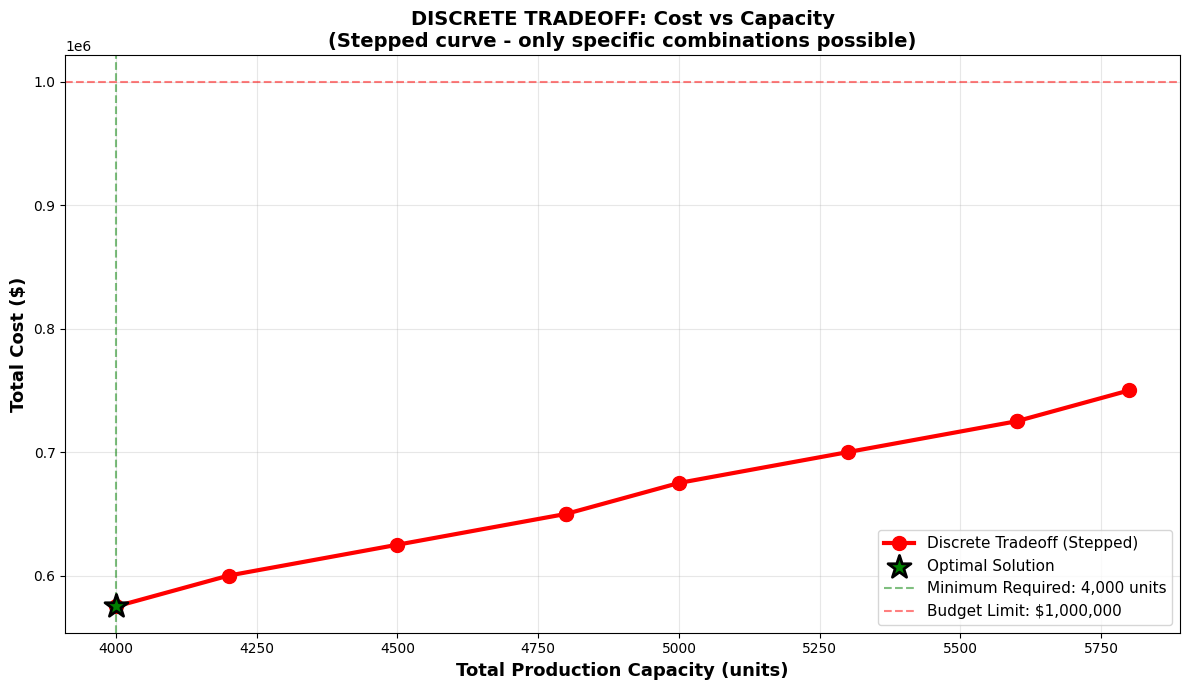


KEY INSIGHT:
The tradeoff curve is STEPPED, not smooth.
You can only achieve specific cost-capacity combinations.
Gaps exist where tradeoff levels are impossible!


In [7]:
# Explore different capacity requirements to see tradeoff
capacity_levels = np.arange(min_production_capacity, min_production_capacity + 2000, 200)
costs_at_capacity = []
capacities_achieved = []

for capacity_req in capacity_levels:
    # Create a new model for this capacity level
    model_tradeoff = LpProblem("Facility_Expansion_Tradeoff", LpMinimize)
    
    open_fac_tradeoff = {}
    for f in facilities:
        open_fac_tradeoff[f] = LpVariable(f"open_{f.replace(' ', '_')}", cat='Binary')
    
    machines_tradeoff = {}
    for f in facilities:
        machines_tradeoff[f] = {}
        for m in machine_types:
            machines_tradeoff[f][m] = LpVariable(f"machines_{f.replace(' ', '_')}_{m.replace(' ', '_')}", 
                                                 lowBound=0, cat='Integer')
    
    model_tradeoff += (lpSum([fixed_costs[f] * open_fac_tradeoff[f] for f in facilities]) +
                      lpSum([machine_costs[m] * machines_tradeoff[f][m] 
                             for f in facilities for m in machine_types])), "Total_Cost"
    
    model_tradeoff += (lpSum([machine_capacities[m] * machines_tradeoff[f][m] 
                             for f in facilities for m in machine_types]) >= capacity_req, 
                      "Min_Production")
    
    model_tradeoff += (lpSum([fixed_costs[f] * open_fac_tradeoff[f] for f in facilities]) +
                      lpSum([machine_costs[m] * machines_tradeoff[f][m] 
                             for f in facilities for m in machine_types]) <= total_budget, 
                      "Budget")
    
    for f in facilities:
        for m in machine_types:
            model_tradeoff += machines_tradeoff[f][m] <= M * open_fac_tradeoff[f], \
                             f"Logic_{f.replace(' ', '_')}_{m.replace(' ', '_')}"
    
    model_tradeoff.solve()
    
    if model_tradeoff.status == 1:
        cost = value(model_tradeoff.objective)
        capacity = sum([machine_capacities[m] * int(value(machines_tradeoff[f][m])) 
                       for f in facilities for m in machine_types])
        costs_at_capacity.append(cost)
        capacities_achieved.append(capacity)
    else:
        costs_at_capacity.append(None)
        capacities_achieved.append(None)

# Plot the tradeoff
fig, ax = plt.subplots(figsize=(12, 7))

# Filter out infeasible points
feasible_costs = [c for c in costs_at_capacity if c is not None]
feasible_capacities = [cap for cap, c in zip(capacities_achieved, costs_at_capacity) if c is not None]

if len(feasible_costs) > 0:
    ax.plot(feasible_capacities, feasible_costs, 'ro-', linewidth=3, markersize=10, 
           label='Discrete Tradeoff (Stepped)', zorder=3)
    
    # Highlight the optimal solution
    if model.status == 1:
        opt_capacity = sum([machine_capacities[m] * int(value(machines[f][m])) 
                           for f in facilities for m in machine_types])
        opt_cost = value(model.objective)
        ax.scatter([opt_capacity], [opt_cost], s=300, color='green', marker='*', 
                  edgecolors='black', linewidths=2, zorder=4, label='Optimal Solution')
    
    ax.axvline(x=min_production_capacity, color='g', linestyle='--', alpha=0.5, 
              label=f'Minimum Required: {min_production_capacity:,} units')
    ax.axhline(y=total_budget, color='r', linestyle='--', alpha=0.5, 
              label=f'Budget Limit: ${total_budget:,}')
    
    ax.set_xlabel('Total Production Capacity (units)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Total Cost ($)', fontsize=13, fontweight='bold')
    ax.set_title('DISCRETE TRADEOFF: Cost vs Capacity\n(Stepped curve - only specific combinations possible)', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11, loc='best')
    
    plt.tight_layout()
    plt.show()
    
    print("\nKEY INSIGHT:")
    print("=" * 70)
    print("The tradeoff curve is STEPPED, not smooth.")
    print("You can only achieve specific cost-capacity combinations.")
    print("Gaps exist where tradeoff levels are impossible!")
    print("=" * 70)
else:
    print("No feasible solutions found for the tested capacity levels.")


## Step 8: Interpret the Solution

How do we interpret this discrete solution for decision-makers?


In [8]:
if model.status == 1:
    print("INTERPRETING THE INTEGER SOLUTION:")
    print("=" * 70)
    print("\n1. FACILITY DECISIONS (Binary - Yes/No):")
    print("-" * 70)
    for f in facilities:
        is_open = value(open_facility[f]) > 0.5
        if is_open:
            print(f"   ✓ OPEN {f}")
            print(f"     - This is a discrete choice: facility is either OPEN or CLOSED")
            print(f"     - Cannot partially open (e.g., 0.7 open)")
            print(f"     - Fixed cost: ${fixed_costs[f]:,}")
        else:
            print(f"   ✗ CLOSE {f}")
            print(f"     - This is a discrete choice: facility is either OPEN or CLOSED")
            print(f"     - No cost if closed")
    
    print("\n2. MACHINE PURCHASES (Integer - Whole Numbers):")
    print("-" * 70)
    for f in facilities:
        if value(open_facility[f]) > 0.5:
            print(f"\n   {f}:")
            for m in machine_types:
                num_machines = int(value(machines[f][m]))
                if num_machines > 0:
                    print(f"     • Purchase {num_machines} units of {m}")
                    print(f"       - This is a discrete choice: must buy whole machines")
                    print(f"       - Cannot buy 2.5 machines - must buy 2 or 3")
                    print(f"       - Cost: {num_machines} × ${machine_costs[m]:,} = ${num_machines * machine_costs[m]:,}")
                    print(f"       - Capacity: {num_machines} × {machine_capacities[m]:,} = {num_machines * machine_capacities[m]:,} units")
    
    print("\n3. KEY INTERPRETATION POINTS:")
    print("-" * 70)
    print("   • All decisions are DISCRETE (binary or integer)")
    print("   • You cannot fine-tune these solutions by small amounts")
    print("   • If you want to reduce cost slightly, you must:")
    print("     - Close an entire facility, OR")
    print("     - Reduce machines by whole numbers (e.g., 3→2, not 3→2.5)")
    print("   • This creates 'chunky' solutions with gaps in tradeoff options")
    
    print("\n4. IMPLEMENTATION CHECKLIST:")
    print("-" * 70)
    print("   ✓ Solution uses whole numbers (implementable)")
    print("   ✓ All constraints satisfied (valid)")
    print("   ✓ Logical constraints satisfied (machines only in open facilities)")
    print("   ✓ Ready for implementation")
    
    print("\n" + "=" * 70)


INTERPRETING THE INTEGER SOLUTION:

1. FACILITY DECISIONS (Binary - Yes/No):
----------------------------------------------------------------------
   ✓ OPEN Facility A
     - This is a discrete choice: facility is either OPEN or CLOSED
     - Cannot partially open (e.g., 0.7 open)
     - Fixed cost: $200,000
   ✗ CLOSE Facility B
     - This is a discrete choice: facility is either OPEN or CLOSED
     - No cost if closed
   ✗ CLOSE Facility C
     - This is a discrete choice: facility is either OPEN or CLOSED
     - No cost if closed

2. MACHINE PURCHASES (Integer - Whole Numbers):
----------------------------------------------------------------------

   Facility A:
     • Purchase 5 units of Machine Type Y
       - This is a discrete choice: must buy whole machines
       - Cannot buy 2.5 machines - must buy 2 or 3
       - Cost: 5 × $75,000 = $375,000
       - Capacity: 5 × 800 = 4,000 units

3. KEY INTERPRETATION POINTS:
------------------------------------------------------------

## Summary: All Concepts Integrated

This comprehensive example demonstrates how all Lesson 7 concepts work together:

**1. Discrete vs Continuous Decisions:**
- Facilities: Binary (open/closed) - cannot partially open
- Machines: Integer (whole numbers) - cannot buy fractional machines

**2. Integer Constraints in Modeling:**
- Used binary variables for facility decisions
- Used integer variables for machine purchases
- Combined both types in one model

**3. Feasibility Challenges:**
- Tight constraints can make the problem infeasible
- Integer constraints reduce feasible options
- Must balance constraints carefully

**4. Discrete Tradeoffs:**
- Cost vs capacity tradeoff is stepped, not smooth
- Gaps exist where certain tradeoff levels are impossible
- Cannot fine-tune tradeoffs the way you can with continuous decisions

**5. Interpreting Integer Solutions:**
- Solutions are discrete choices (whole numbers)
- Cannot adjust by small amounts
- Must validate that solutions are implementable

**6. Over-constraining:**
- Too many tight constraints can eliminate all feasible solutions
- Must be careful about constraint tightness with integer variables
- May need to relax constraints to find feasible solutions

**Key Takeaway:**
Discrete optimization requires different thinking than continuous optimization. You must recognize when decisions are discrete, model them correctly, understand the limitations of discrete solutions, and communicate them effectively to stakeholders.
